In [1]:
# Standard library imports
import os
import sys
import pickle
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

# Third-party imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from mapie.regression import MapieQuantileRegressor

# Add paths for local modules
sys.path.append('../src/simulations')
sys.path.append('../src/utils')

# Local application imports
from config import param_bounds, sample_sizes
from common import black_scholes_price

### Generate and Save Simulated Training and Testing Datasets

In [2]:
# Generate data based on seed and strikes_per_S values
def generate_data(seed, strikes_per_S, sample_sizes):
    np.random.seed(seed)  # Set random seed for reproducibility
    total_num_samples = int(sum(sample_sizes) / strikes_per_S)

    # Generate data from uniform distribution for each parameter
    data = {}
    for param in param_bounds.keys():
        data[param] = np.repeat(
            np.random.uniform(
                param_bounds[param][0],  # lower bound
                param_bounds[param][1],  # upper bound
                total_num_samples
            ), strikes_per_S
        )

    # Generate strikes for each S value
    z = np.random.normal(1, 0.1, total_num_samples * strikes_per_S)
    data['K'] = data['S'] / z

    # Calculate 'moneyness' and add it directly to the data dictionary
    data['moneyness'] = data['S'] / data['K']

    # Convert data dictionary to DataFrame
    data = pd.DataFrame(data)

    # Assign sample IDs according to sample_sizes
    data['sample_id'] = 0
    for i, size in enumerate(sample_sizes):
        data.loc[
            data.index.isin(range(sum(sample_sizes[:i]), sum(sample_sizes[:i+1]))),
            'sample_id'
        ] = i

    # Calculate option price
    data['C'] = black_scholes_price(data['S'], data['K'], data['r'], data['sigma'], data['tau'], option_type="call")
    
    # Calculate relative price (C/K ratio)
    data['C_to_K'] = data['C'] / data['K']

    return data

In [3]:
# Save generated data to a CSV file
def save_data(data, seed, strikes_per_S, data_type="train"):
    output_dir = Path("../data/simulated")
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = f"{data_type}_{seed}_{strikes_per_S}.csv"
    file_path = output_dir / filename
    data.to_csv(file_path, index=False)
    print(f"Data saved to {file_path}")

In [4]:
# Create a dictionary of samples based on sample sizes
def create_sample_dict(data, sample_sizes):
    return {
        f"sample_{size}": data[data['sample_id'] == i]
        for i, size in enumerate(sample_sizes)
    }

### Load Best LightGBM Hyperparameters

In [5]:
# Define file paths for results of all samples
results_train_paths = [f'../models/simulation_1/sample_{i}/results_train.csv' for i in range(len(sample_sizes))]
results_proper_train_paths = [f'../models/simulation_1/sample_{i}/results_proper_train.csv' for i in range(len(sample_sizes))]

# Load the best hyperparameters from a result file
def load_best_hyperparameters(results_path):
    results = pd.read_csv(results_path)
    best_params = results.loc[results['mae'].idxmin()]
    return {
        'n_estimators': int(best_params['n_estimators']),
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'learning_rate': float(best_params['learning_rate'])
    }

# Load best hyperparameters for CQR and NQR
best_hyperparameters_cqr = [load_best_hyperparameters(path) for path in results_train_paths]
best_hyperparameters_nqr = [load_best_hyperparameters(path) for path in results_proper_train_paths]

# Display best hyperparameters for each sample
print("Best Hyperparameters for CQR:")
for i, params in enumerate(best_hyperparameters_cqr):
    print(f"sample_{sample_sizes[i]}: {params}")

print("\nBest Hyperparameters for NQR:")
for i, params in enumerate(best_hyperparameters_nqr):
    print(f"sample_{sample_sizes[i]}: {params}")

Best Hyperparameters for CQR:
sample_5000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 16, 'learning_rate': 0.01}
sample_10000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 64, 'learning_rate': 0.01}
sample_20000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 64, 'learning_rate': 0.01}
sample_50000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 16, 'learning_rate': 0.01}
sample_100000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 32, 'learning_rate': 0.01}
sample_200000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 64, 'learning_rate': 0.01}

Best Hyperparameters for NQR:
sample_5000: {'n_estimators': 5000, 'num_leaves': 128, 'max_depth': 32, 'learning_rate': 0.01}
sample_10000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 64, 'learning_rate': 0.01}
sample_20000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 32, 'learning_rate': 0.01}
sample_50000: {'n_estimators': 5000, 'num_leaves': 256, 'max_depth': 16, 'l

### Model Initialization and Run Configuration

In [6]:
# Load a model if it exists, updating the progress bar
def load_model_if_exists(model_path, pbar, desc):
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        pbar.set_description(desc + " (Model loaded)")
        pbar.update(1)
        return model
    return None

In [7]:
# Save a model if required, updating the progress bar
def save_model_if_needed(model, model_path, save_flag, pbar, desc):
    if save_flag:
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        pbar.set_description(desc + " (Model saved)")
        pbar.update(1)

### Conformal Quantile Regression (CQR) using MAPIE

In [8]:
# Perform CQR with LightGBM using MAPIE for calibration
def cqr(train_data, test_data, strikes_per_S, sample_index, sample_size, refit_cqr=True, save_cp_models=True, load_cp_models=False):
    base_path = f'../models/simulation_figures/sample_{sample_index}/'
    os.makedirs(base_path, exist_ok=True)
    model_path = os.path.join(base_path, f'cqr_model_k_{strikes_per_S}_{sample_size}.pkl')
    intervals_cqr_path = os.path.join(base_path, f'cqr_intervals_k_{strikes_per_S}_{sample_size}.csv')

    X = train_data[['moneyness', 'sigma', 'tau', 'r']]
    y = train_data['C_to_K']

    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Adjust steps based on whether we load or train the model
    total_steps = 2 if load_cp_models and not refit_cqr else 3
    with tqdm(total=total_steps, desc=f"CQR model (k={strikes_per_S}, size={sample_size})") as pbar:
        
        # Branch based on loading or training
        if load_cp_models:
            mapie = load_model_if_exists(model_path, pbar, desc="Loading CQR model")
        else:
            mapie = None
        
        # Train if needed (either refit is True, or load failed)
        if refit_cqr or mapie is None:
            params = best_hyperparameters_cqr[sample_index]
            estimator = lgb.LGBMRegressor(**params, objective='quantile', alpha=0.5, n_jobs=-1, verbosity=-1, random_state=123456)
            mapie = MapieQuantileRegressor(estimator, alpha=0.01, method='quantile', cv='split')
            mapie.fit(X_proper_train, y_proper_train, X_calib=X_cal, y_calib=y_cal, random_state=123456)
            pbar.set_description("Training CQR model")
            pbar.update(1)
            save_model_if_needed(mapie, model_path, save_cp_models, pbar, "Saving CQR model")

        X_test = test_data[['moneyness', 'sigma', 'tau', 'r']]
        point_predictions_cqr, prediction_intervals = mapie.predict(X_test)
        intervals_cqr = prediction_intervals.squeeze()

        results_df = pd.DataFrame({
            'Lower Bound': intervals_cqr[:, 0],
            'Upper Bound': intervals_cqr[:, 1],
            'Point Prediction': point_predictions_cqr,
            'y_test': test_data['C_to_K'],
            **{feature: X_test[feature].values for feature in ['moneyness', 'sigma', 'tau', 'r']}
        })
        results_df.to_csv(intervals_cqr_path, index=False)
        pbar.set_description("Saving CQR results")
        pbar.update(1)

    return point_predictions_cqr, intervals_cqr, intervals_cqr_path

### Non-Conformal Quantile Regression (NQR) using Parallelization

In [9]:
# Perform NQR with LightGBM using parallelization
def nqr(train_data, test_data, strikes_per_S, sample_index, sample_size, refit_nqr=True, save_non_cp_models=True, load_non_cp_models=False):
    base_path = f'../models/simulation_figures/sample_{sample_index}/'
    os.makedirs(base_path, exist_ok=True)
    model_path = os.path.join(base_path, f'nqr_model_k_{strikes_per_S}_{sample_size}.pkl')
    intervals_nqr_path = os.path.join(base_path, f'nqr_intervals_k_{strikes_per_S}_{sample_size}.csv')

    X = train_data[['moneyness', 'sigma', 'tau', 'r']]
    y = train_data['C_to_K']
    X_train, X_test_split, y_train, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)

    # Adjust steps based on whether we load or train the model
    total_steps = 2 if load_non_cp_models and not refit_nqr else 3
    with tqdm(total=total_steps, desc=f"NQR model (k={strikes_per_S}, size={sample_size})") as pbar:
        
        # Branch based on loading or training
        if load_non_cp_models:
            model_dict = load_model_if_exists(model_path, pbar, desc="Loading NQR model")
        else:
            model_dict = None
        
        if model_dict:
            lb_estimator, ub_estimator, median_estimator = model_dict['lb_estimator'], model_dict['ub_estimator'], model_dict['median_estimator']
        else:
            params = best_hyperparameters_nqr[sample_index]
            lb_estimator = lgb.LGBMRegressor(**params, objective='quantile', alpha=0.05, n_jobs=-1, verbosity=-1, random_state=123456)
            ub_estimator = lgb.LGBMRegressor(**params, objective='quantile', alpha=0.95, n_jobs=-1, verbosity=-1, random_state=123456)
            median_estimator = lgb.LGBMRegressor(**params, objective='quantile', alpha=0.5, n_jobs=-1, verbosity=-1, random_state=123456)
            
            with ThreadPoolExecutor(max_workers=3) as executor:
                futures = {
                    executor.submit(estimator.fit, X_train, y_train): estimator_name
                    for estimator, estimator_name in zip([lb_estimator, ub_estimator, median_estimator], 
                                                         ['lb_estimator', 'ub_estimator', 'median_estimator'])
                }
                for future in futures:
                    try:
                        future.result()
                        pbar.update(1)
                    except Exception as e:
                        print(f"Model training failed: {e}")
            model_dict = {'lb_estimator': lb_estimator, 'ub_estimator': ub_estimator, 'median_estimator': median_estimator}
            save_model_if_needed(model_dict, model_path, save_non_cp_models, pbar, "Saving NQR model")

        X_test = test_data[['moneyness', 'sigma', 'tau', 'r']]
        point_predictions_nqr = median_estimator.predict(X_test)
        lower_bounds = lb_estimator.predict(X_test)
        upper_bounds = ub_estimator.predict(X_test)
        intervals_nqr = np.vstack([lower_bounds, upper_bounds]).T

        results_df = pd.DataFrame({
            'Lower Bound': intervals_nqr[:, 0],
            'Upper Bound': intervals_nqr[:, 1],
            'Point Prediction': point_predictions_nqr,
            'y_test': test_data['C_to_K'],
            **{feature: X_test[feature].values for feature in ['moneyness', 'sigma', 'tau', 'r']}
        })
        results_df.to_csv(intervals_nqr_path, index=False)
        pbar.set_description("Saving NQR results")
        pbar.update(1)

    return point_predictions_nqr, intervals_nqr, intervals_nqr_path

### Plotting Functions

In [10]:
# Plot covered vs missed for each feature with point predictions
def plot_covered_vs_missed(intervals_path, strikes_per_S, sample_size, method_name, n=1, plot_point_predictions=True, save=True):
    # Directory for saving plots
    save_dir = f"../reports/figures/3.2-nm-figures-mapie/k_{strikes_per_S}_{sample_size}"
    os.makedirs(save_dir, exist_ok=True)

    # Load data from CSV
    data = pd.read_csv(intervals_path)
    features = ['moneyness', 'sigma', 'tau', 'r']
    feature_labels = ['Moneyness (S/K)', 'Volatility (σ)', 'Time-to-Maturity (τ)', 'Interest Rate (r)']

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()
    fig.suptitle(f'{method_name} Coverage Analysis - Strikes per S: {strikes_per_S}, Sample Size: {sample_size}', fontsize=16, y=1.02)

    for i, (feature, label) in tqdm(enumerate(zip(features, feature_labels)), total=len(features), desc="Processing Covered vs Missed"):
        within_interval = (data['Lower Bound'] <= data['y_test']) & (data['y_test'] <= data['Upper Bound'])

        # Plot covered and missed points
        axs[i].scatter(data[feature][within_interval][::n], data['y_test'][within_interval][::n], color='blue', s=10, alpha=0.5, label='Covered')
        axs[i].scatter(data[feature][~within_interval][::n], data['y_test'][~within_interval][::n], color='red', s=10, alpha=0.5, label='Missed')

        # Plot point predictions if enabled
        if plot_point_predictions:
            axs[i].scatter(data[feature][::n], data['Point Prediction'][::n], color='green', marker='x', s=10, alpha=0.5, label='Point Prediction')

        axs[i].set_xlabel(label)
        axs[i].set_ylabel('Call Price (C/K)')
        axs[i].legend(loc='upper left')
        axs[i].set_title(f'{method_name} - {label}')

    if n > 1:
        plt.figtext(0.5, -0.02, f'Note: Displaying every {n}-th data point', ha='center', fontsize=10)

    plt.tight_layout()

    if save:
        # Update filename based on whether point predictions are included
        suffix = "_with_PPs" if plot_point_predictions else ""
        file_name = f"{method_name}_COV_K_{strikes_per_S}_{sample_size}{suffix}.png"
        save_path = os.path.join(save_dir, file_name)
        try:
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved successfully at {save_path}")
        except Exception as e:
            print(f"Failed to save figure: {e}")

    plt.show()

In [11]:
# Plot prediction intervals for each feature with missed actual prices
def plot_prediction_intervals(intervals_path, strikes_per_S, sample_size, method_name, n=1, save=True):
    # Directory for saving plots
    save_dir = f"../reports/figures/3.2-nm-figures-mapie/k_{strikes_per_S}_{sample_size}"
    os.makedirs(save_dir, exist_ok=True)

    # Load data from CSV
    data = pd.read_csv(intervals_path)
    features = ['moneyness', 'sigma', 'tau', 'r']
    feature_labels = ['Moneyness (S/K)', 'Volatility (σ)', 'Time-to-Maturity (τ)', 'Interest Rate (r)']

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()
    fig.suptitle(f'{method_name} Prediction Intervals - Strikes per S: {strikes_per_S}, Sample Size: {sample_size}', fontsize=16, y=1.02)

    for i, (feature, label) in tqdm(enumerate(zip(features, feature_labels)), total=len(features), desc="Processing Prediction Intervals"):
        covered_added = missed_added = False  # Track legend entries for each plot

        for j in range(0, len(data), n):
            x_value = data[feature].iloc[j]
            lower_bound, upper_bound = data['Lower Bound'].iloc[j], data['Upper Bound'].iloc[j]
            actual_price = data['y_test'].iloc[j]

            # Determine if actual price is covered or missed by the interval
            if lower_bound <= actual_price <= upper_bound:
                color = 'black'
                line_label = 'Covered Interval' if not covered_added else None
                covered_added = True
            else:
                color = 'gray'
                line_label = 'Missed Interval' if not missed_added else None
                missed_added = True

            # Plot prediction interval
            axs[i].plot([x_value, x_value], [lower_bound, upper_bound], color=color, linewidth=1, alpha=0.5, label=line_label)

            # Plot missed actual price
            if actual_price < lower_bound or actual_price > upper_bound:
                missed_label = 'Missed Actual Price' if not missed_added else None
                axs[i].scatter(x_value, actual_price, color='red', s=10, alpha=0.5, label=missed_label)
                missed_added = True

        axs[i].set_xlabel(label)
        axs[i].set_ylabel('Call Price (C/K)')
        axs[i].set_title(f'Prediction Intervals ({method_name}) - {label}')
        axs[i].legend(loc='upper left')

    if n > 1:
        plt.figtext(0.5, -0.02, f'Note: Displaying every {n}-th data point', ha='center', fontsize=10)

    plt.tight_layout()

    if save:
        try:
            file_name = f"{method_name}_PIs_K_{strikes_per_S}_{sample_size}.png"
            save_path = os.path.join(save_dir, file_name)
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved successfully at {save_path}")
        except Exception as e:
            print(f"Failed to save figure: {e}")

    plt.show()

### Data Generation, CQR and NQR Model Training, and Evaluation

In [12]:
# Return flags for model operations based on training mode
def configure_flags(training_mode):
    if training_mode:
        return True, True, False, True, True, False
    else:
        return False, False, True, False, False, True

**Experiment 1: Strikes per S = 4, Sample Size = 5000**

In [13]:
# Set strikes_per_S value
strikes_per_S = 4

# Generate and save training and testing data
train_data = generate_data(seed=123456, strikes_per_S=strikes_per_S, sample_sizes=sample_sizes)
save_data(train_data, seed=123456, strikes_per_S=strikes_per_S, data_type="train")

test_data = generate_data(seed=98765, strikes_per_S=strikes_per_S, sample_sizes=sample_sizes)
save_data(test_data, seed=98765, strikes_per_S=strikes_per_S, data_type="test")

# Store generated samples in a dictionary for easy access
samples_dict = create_sample_dict(train_data, sample_sizes)

# Preview training and test data
print("Training Data Preview:")
display(train_data.head())

print("\nTesting Data Preview:")
display(test_data.head())

Data saved to ..\data\simulated\train_123456_4.csv
Data saved to ..\data\simulated\test_98765_4.csv
Training Data Preview:


S     sigma       tau         r           K  moneyness  sample_id  \
0  563.484917  0.283213  0.103238  0.024120  590.325872   0.954532          0   
1  563.484917  0.283213  0.103238  0.024120  577.181074   0.976271          0   
2  563.484917  0.283213  0.103238  0.024120  709.027220   0.794730          0   
3  563.484917  0.283213  0.103238  0.024120  528.887423   1.065416          0   
4  983.358919  0.800311  1.738972  0.026128  876.087273   1.122444          0   

            C    C_to_K  
0   10.623483  0.017996  
1   15.116507  0.026190  
2    0.115945  0.000164  
3   42.717661  0.080769  
4  443.136637  0.505813


Testing Data Preview:


S     sigma       tau         r            K  moneyness  \
0  544.449300  0.940218  1.193053  0.029113   493.195358   1.103922   
1  544.449300  0.940218  1.193053  0.029113   517.559268   1.051955   
2  544.449300  0.940218  1.193053  0.029113   620.346438   0.877654   
3  544.449300  0.940218  1.193053  0.029113   547.685896   0.994090   
4  973.721667  0.253313  1.201849  0.027770  1195.968526   0.814170   

   sample_id           C    C_to_K  
0          0  235.867834  0.478244  
1          0  227.819895  0.440181  
2          0  197.902695  0.319020  
3          0  218.408283  0.398784  
4          0   47.853496  0.040012

In [14]:
# Execute and display results for the selected sample
sample_index = 0  # Example index for the sample size
sample_size = sample_sizes[sample_index]  # Set sample_size based on index

# Set training mode
training_mode = True
refit_cqr, save_cp_models, load_cp_models, refit_nqr, save_non_cp_models, load_non_cp_models = configure_flags(training_mode)

# Calculate intervals using CQR and NQR models
_, _, intervals_cqr_path = cqr(train_data, test_data, strikes_per_S, sample_index, sample_size,
                               refit_cqr=refit_cqr, save_cp_models=save_cp_models, load_cp_models=load_cp_models)
_, _, intervals_nqr_path = nqr(train_data, test_data, strikes_per_S, sample_index, sample_size,
                               refit_nqr=refit_nqr, save_non_cp_models=save_non_cp_models, load_non_cp_models=load_non_cp_models)

Saving CQR model (Model saved):  67%|██████▋   | 2/3 [19:48<08:17, 497.94s/it] C:\Users\jazzn\anaconda3\envs\aqf\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
C:\Users\jazzn\anaconda3\envs\aqf\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
Saving CQR results: 100%|██████████| 3/3 [40:56<00:00, 818.90s/it]            
Saving NQR results: : 5it [17:48, 213.72s/it]                                 


Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_4_5000\CQR_COV_K_4_5000.png


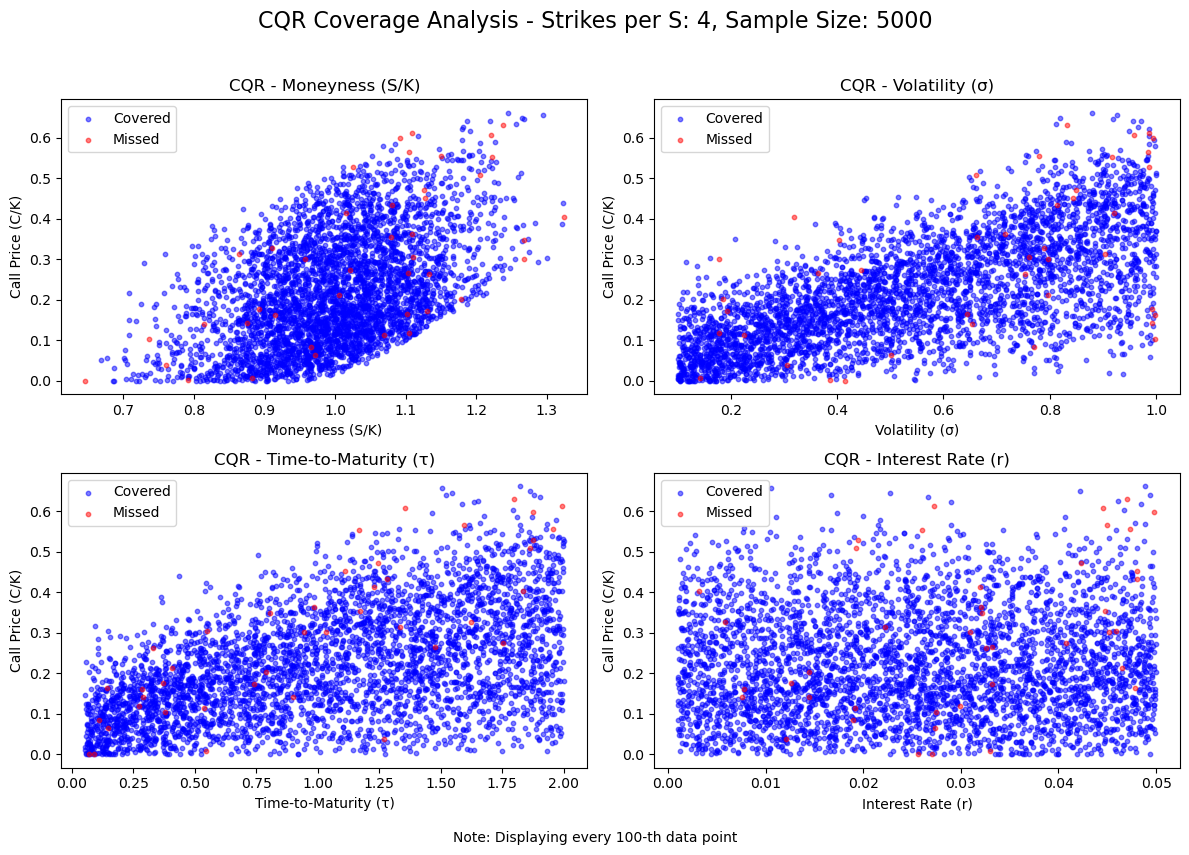

Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_4_5000\CQR_COV_K_4_5000_with_PPs.png


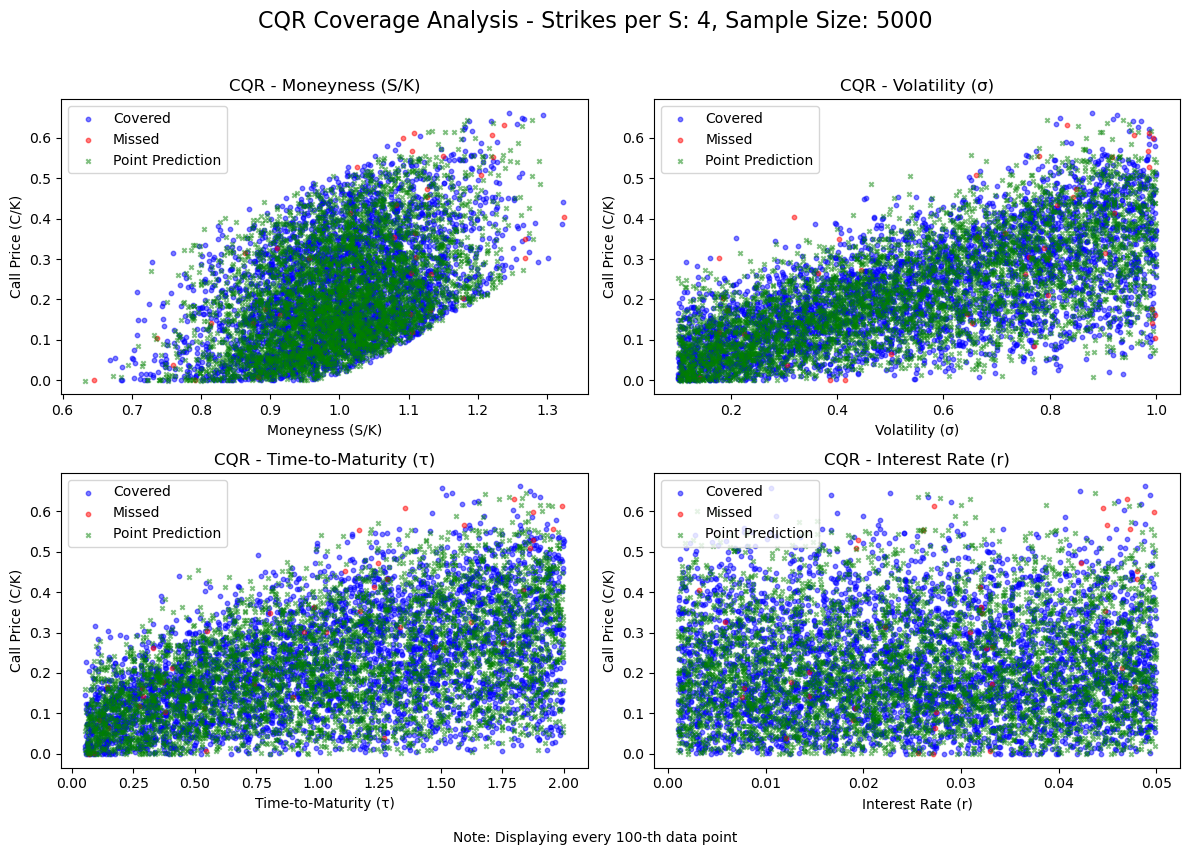

Processing Prediction Intervals: 100%|██████████| 4/4 [01:24<00:00, 21.03s/it]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_4_5000\CQR_PIs_K_4_5000.png


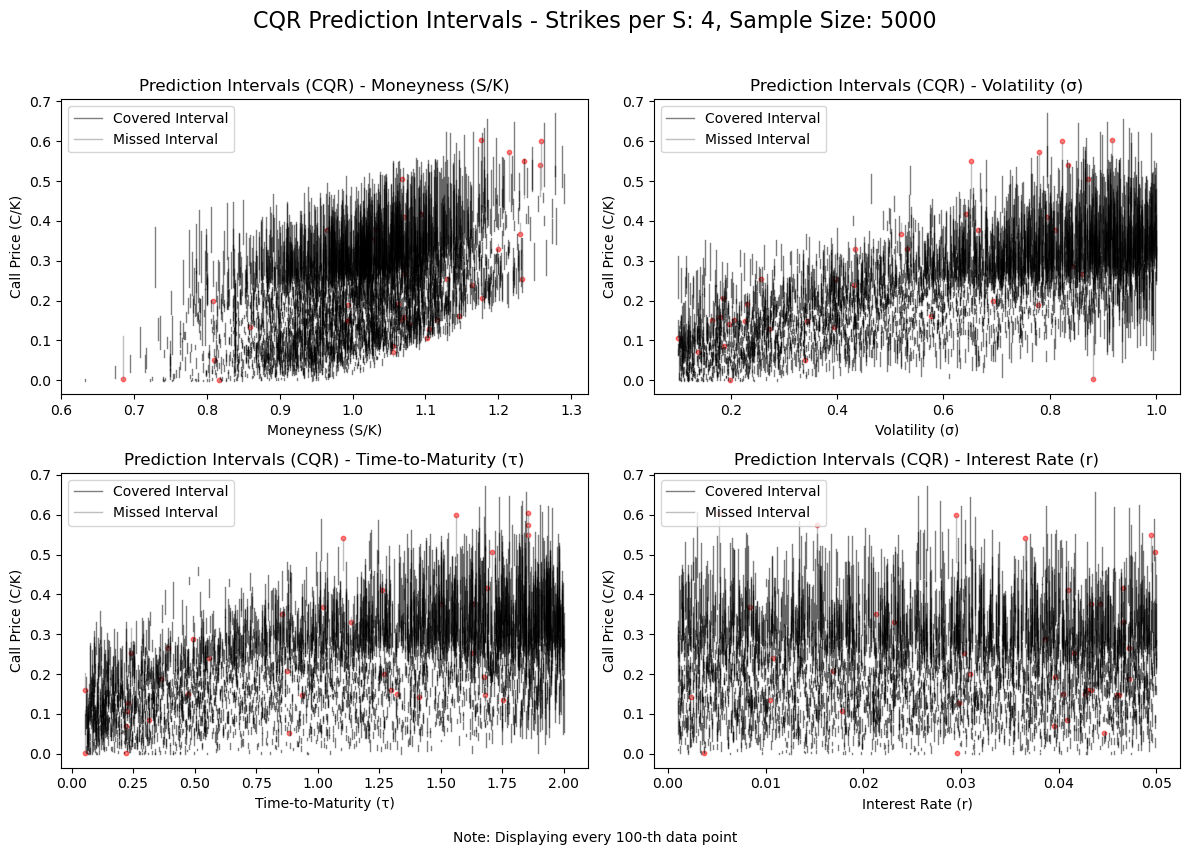

Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00, 17.73it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_4_5000\NQR_COV_K_4_5000.png


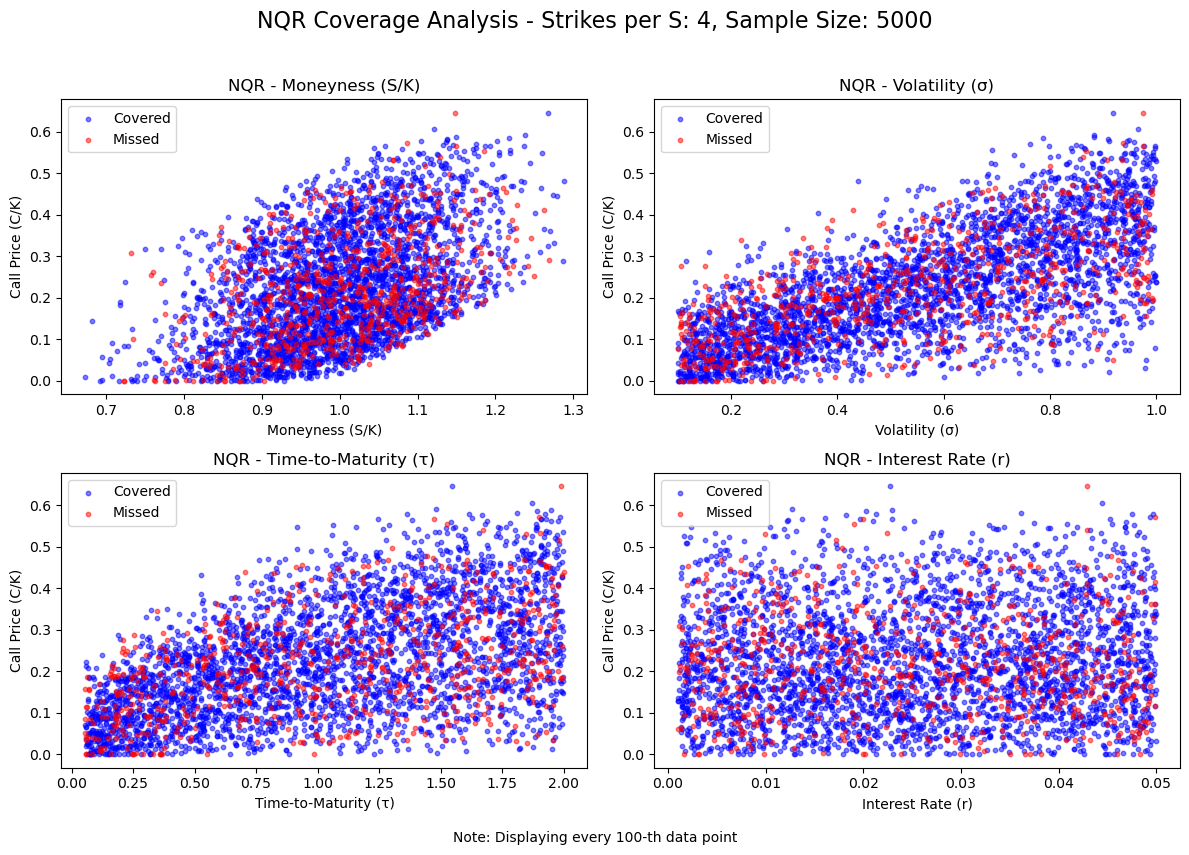

Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00, 17.10it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_4_5000\NQR_COV_K_4_5000_with_PPs.png


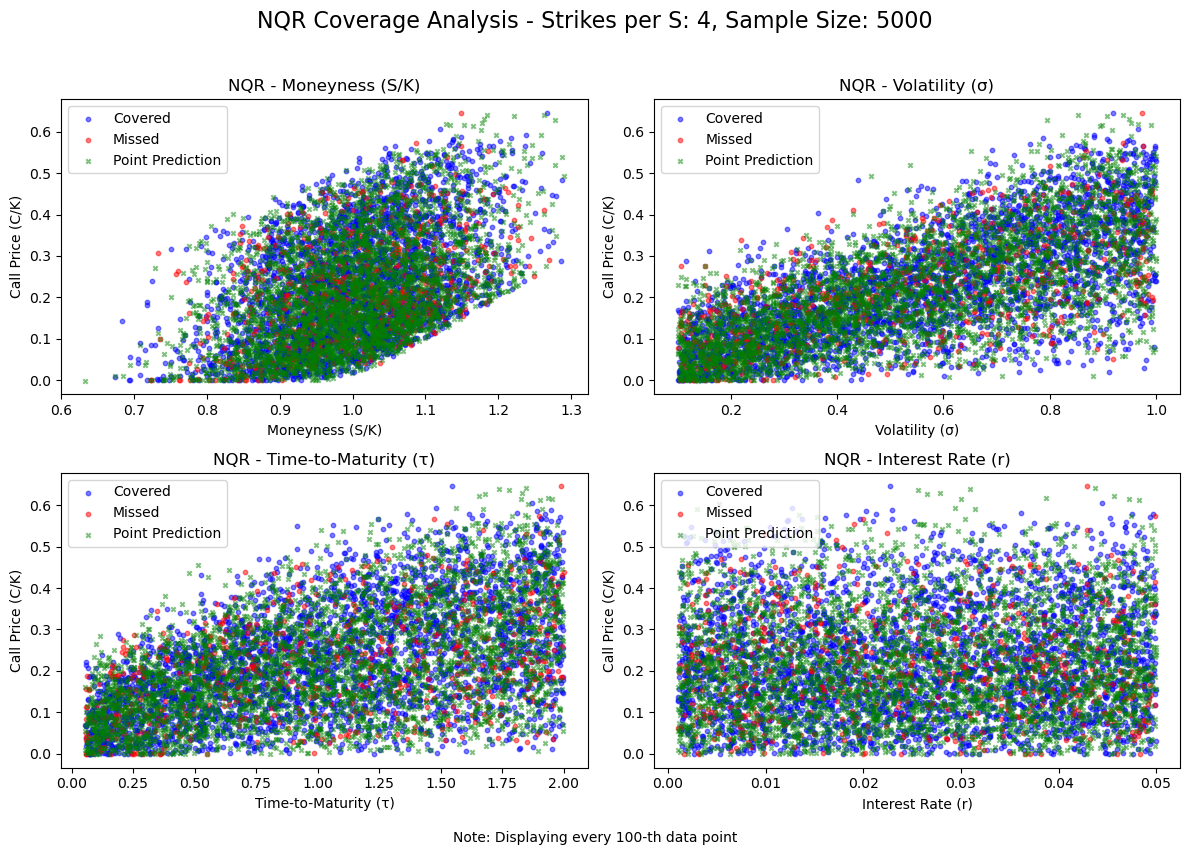

Processing Prediction Intervals: 100%|██████████| 4/4 [01:16<00:00, 19.24s/it]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_4_5000\NQR_PIs_K_4_5000.png


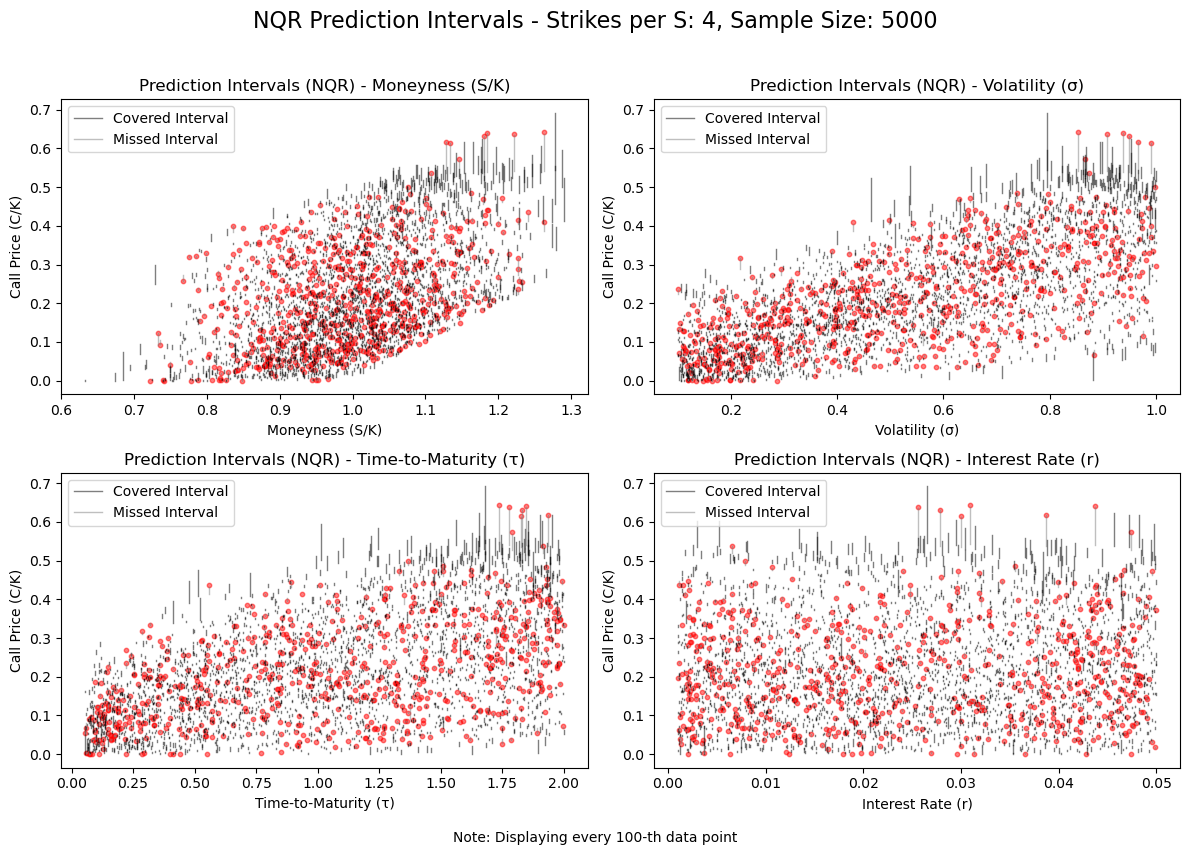

In [15]:
# Plot results for CQR
plot_covered_vs_missed(intervals_cqr_path, strikes_per_S, sample_size, 'CQR', n=100, plot_point_predictions=False)
plot_covered_vs_missed(intervals_cqr_path, strikes_per_S, sample_size, 'CQR', n=100, plot_point_predictions=True)
plot_prediction_intervals(intervals_cqr_path, strikes_per_S, sample_size, 'CQR', n=100)

# Plot results for NQR
plot_covered_vs_missed(intervals_nqr_path, strikes_per_S, sample_size, 'NQR', n=100, plot_point_predictions=False)
plot_covered_vs_missed(intervals_nqr_path, strikes_per_S, sample_size, 'NQR', n=100, plot_point_predictions=True)
plot_prediction_intervals(intervals_nqr_path, strikes_per_S, sample_size, 'NQR', n=100)

**Experiment 2: Strikes per S = 1, Sample Size = 5000**

In [16]:
# Set strikes_per_S value
strikes_per_S = 1

# Generate and save training and testing data
train_data = generate_data(seed=123456, strikes_per_S=strikes_per_S, sample_sizes=sample_sizes)
save_data(train_data, seed=123456, strikes_per_S=strikes_per_S, data_type="train")

test_data = generate_data(seed=98765, strikes_per_S=strikes_per_S, sample_sizes=sample_sizes)
save_data(test_data, seed=98765, strikes_per_S=strikes_per_S, data_type="test")

# Store generated samples in a dictionary for easy access
samples_dict = create_sample_dict(train_data, sample_sizes)

# Preview training and test data
print("Training Data Preview:")
display(train_data.head())

print("\nTesting Data Preview:")
display(test_data.head())

Data saved to ..\data\simulated\train_123456_1.csv
Data saved to ..\data\simulated\test_98765_1.csv
Training Data Preview:


S     sigma       tau         r           K  moneyness  sample_id  \
0  563.484917  0.355048  0.371405  0.044031  541.994321   1.039651          0   
1  983.358919  0.176452  1.075096  0.040882  818.419684   1.201534          0   
2  630.238003  0.592817  0.118199  0.044630  620.848391   1.015124          0   
3  948.618262  0.415642  1.718612  0.045837  910.941459   1.041360          0   
4  688.374858  0.551973  0.955630  0.011697  607.911542   1.132360          0   

            C    C_to_K  
0   63.907604  0.117912  
1  208.337407  0.254561  
2   57.219516  0.092163  
3  250.046027  0.274492  
4  184.928437  0.304203


Testing Data Preview:


S     sigma       tau         r           K  moneyness  sample_id  \
0  544.449300  0.693590  0.394603  0.035176  548.030618   0.993465          0   
1  973.721667  0.837211  0.150696  0.049923  793.194272   1.227595          0   
2  899.097200  0.535080  0.789780  0.034277  858.472291   1.047322          0   
3  635.952896  0.241107  1.335702  0.030665  654.771825   0.971259          0   
4  678.161862  0.498170  1.637159  0.022942  837.265792   0.809972          0   

            C    C_to_K  
0   95.548448  0.174349  
1  230.065159  0.290049  
2  196.671657  0.229095  
3   73.846950  0.112783  
4  128.051156  0.152940

In [17]:
# Execute and display results for the selected sample
sample_index = 0  # Example index for the sample size
sample_size = sample_sizes[sample_index]  # Set sample_size based on index

# Set training mode
training_mode = True
refit_cqr, save_cp_models, load_cp_models, refit_nqr, save_non_cp_models, load_non_cp_models = configure_flags(training_mode)

# Calculate intervals using CQR and NQR models
_, _, intervals_cqr_path = cqr(train_data, test_data, strikes_per_S, sample_index, sample_size,
                               refit_cqr=refit_cqr, save_cp_models=save_cp_models, load_cp_models=load_cp_models)
_, _, intervals_nqr_path = nqr(train_data, test_data, strikes_per_S, sample_index, sample_size,
                               refit_nqr=refit_nqr, save_non_cp_models=save_non_cp_models, load_non_cp_models=load_non_cp_models)

Saving CQR model (Model saved):  67%|██████▋   | 2/3 [19:46<08:12, 492.81s/it] C:\Users\jazzn\anaconda3\envs\aqf\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
C:\Users\jazzn\anaconda3\envs\aqf\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
Saving CQR results: 100%|██████████| 3/3 [36:51<00:00, 737.12s/it]            
Saving NQR results: : 5it [19:31, 234.33s/it]                                 


Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_1_5000\CQR_COV_K_1_5000.png


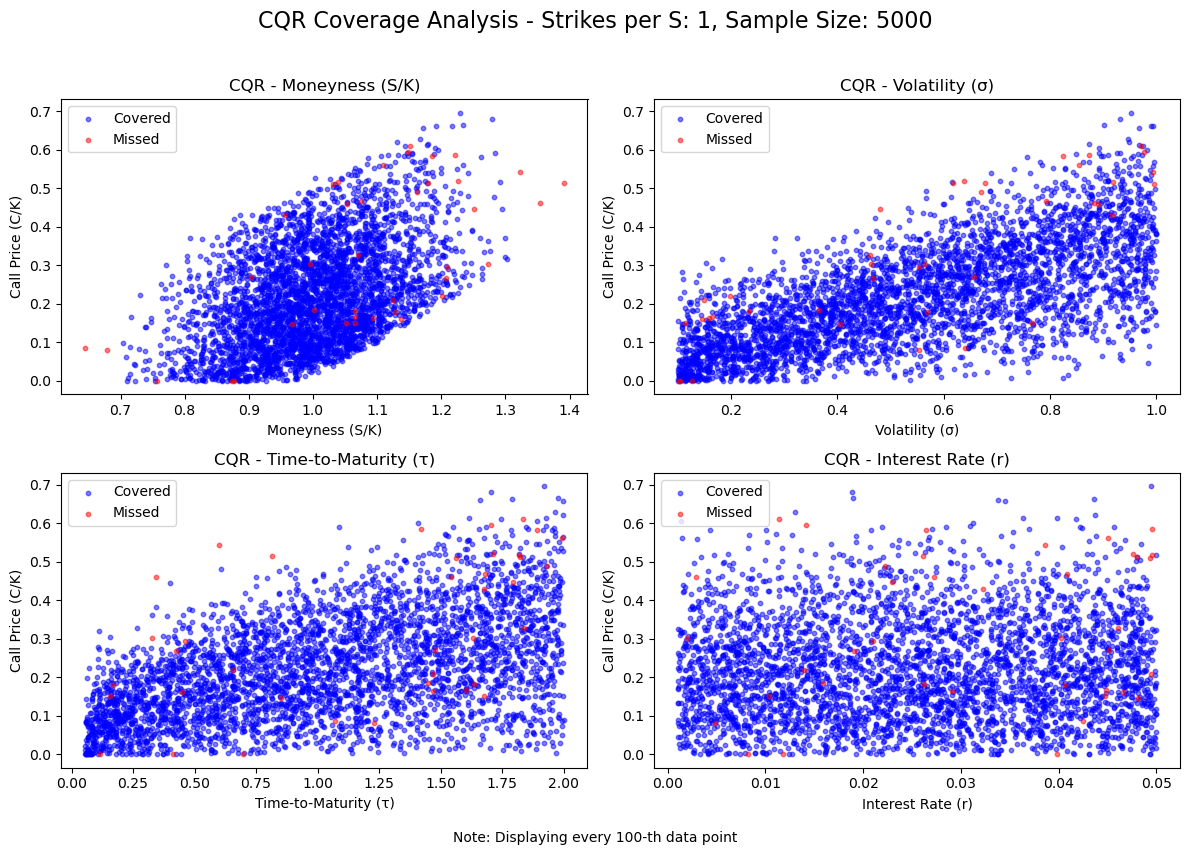

Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_1_5000\CQR_COV_K_1_5000_with_PPs.png


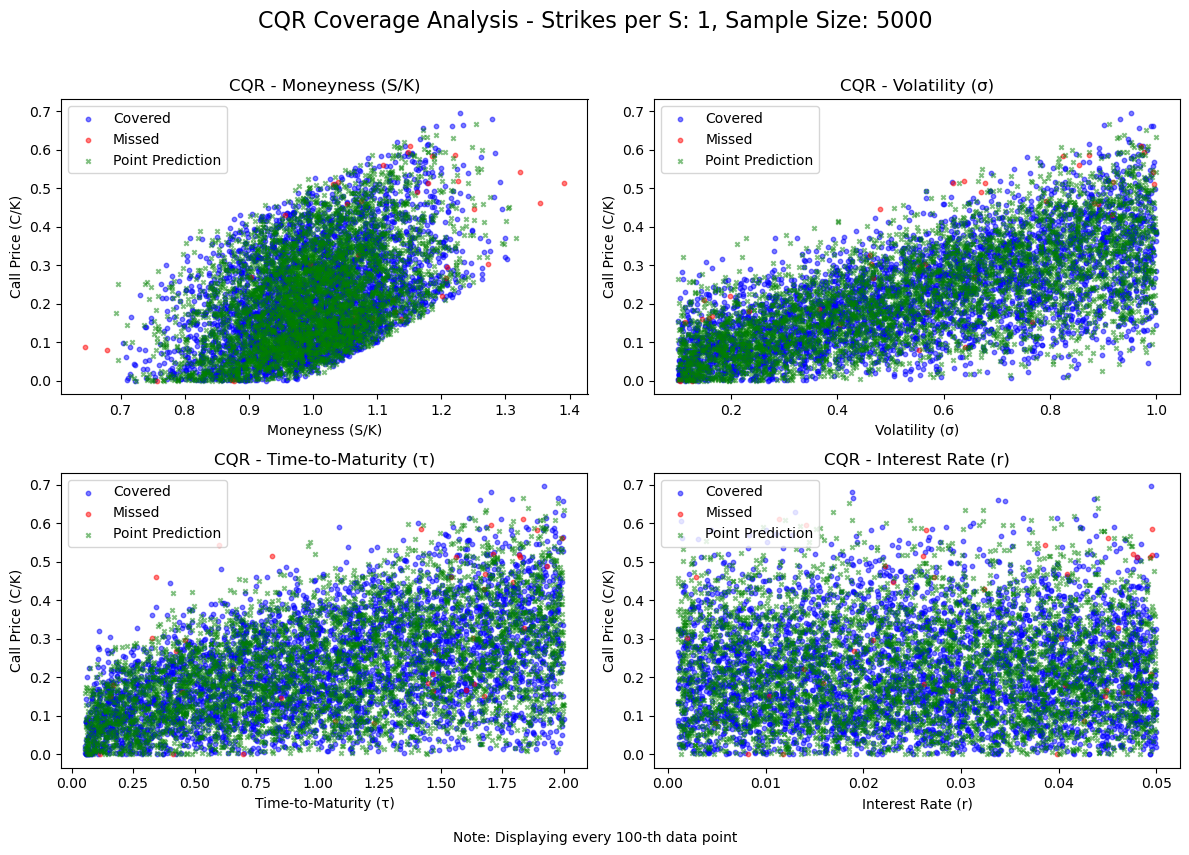

Processing Prediction Intervals: 100%|██████████| 4/4 [01:01<00:00, 15.38s/it]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_1_5000\CQR_PIs_K_1_5000.png


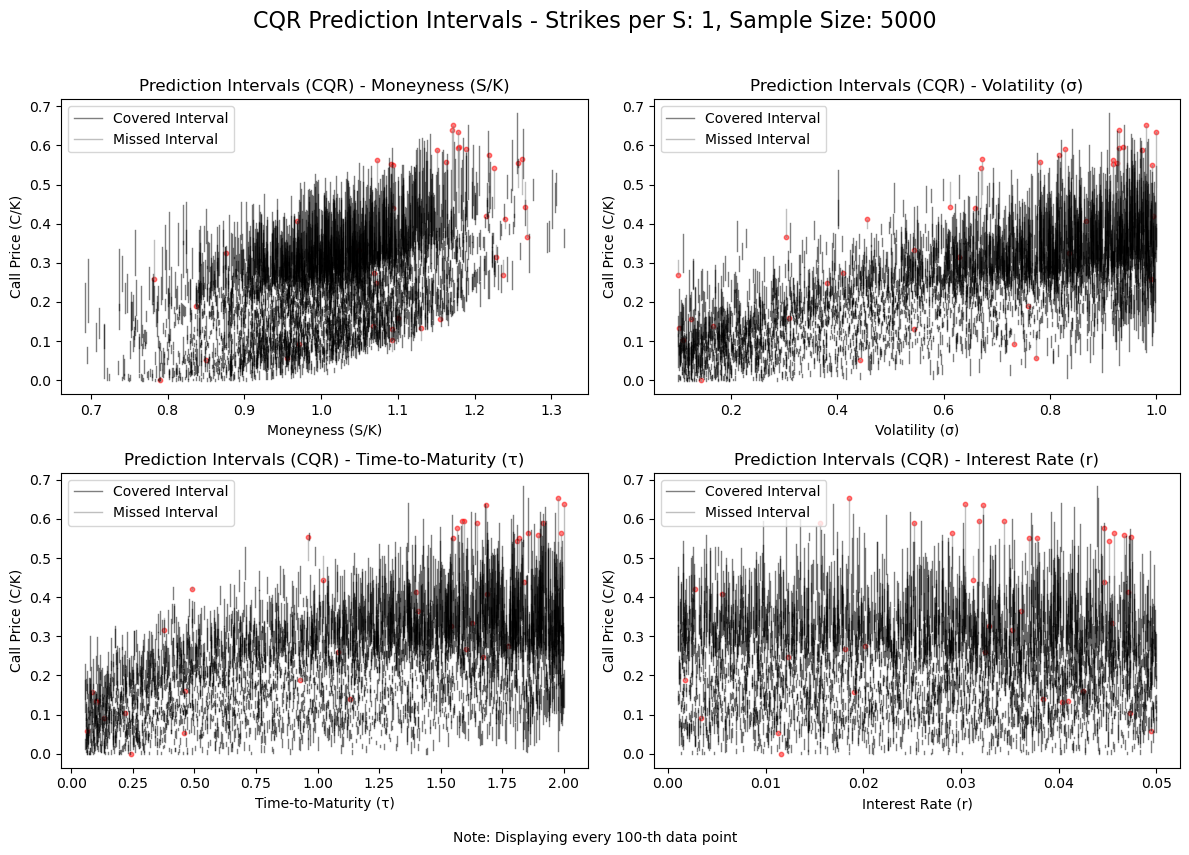

Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00, 13.31it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_1_5000\NQR_COV_K_1_5000.png


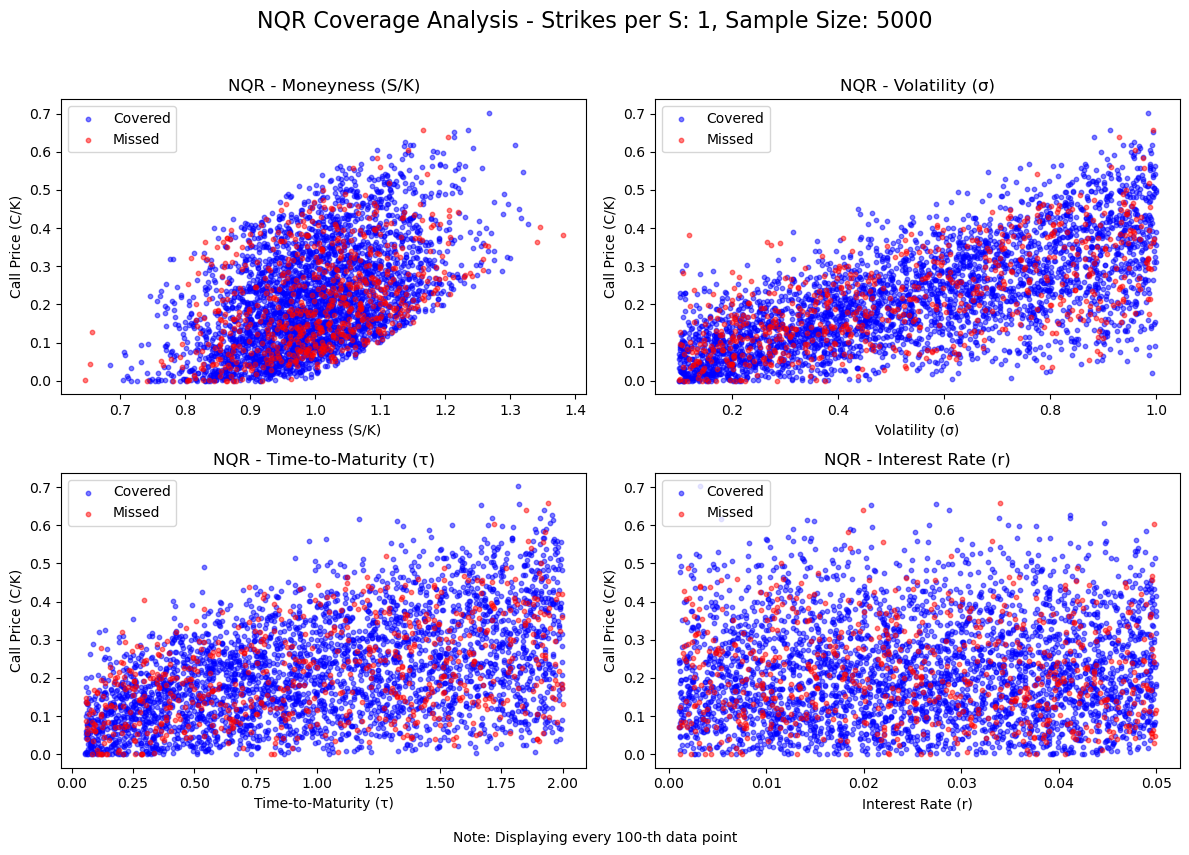

Processing Covered vs Missed: 100%|██████████| 4/4 [00:00<00:00,  9.90it/s]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_1_5000\NQR_COV_K_1_5000_with_PPs.png


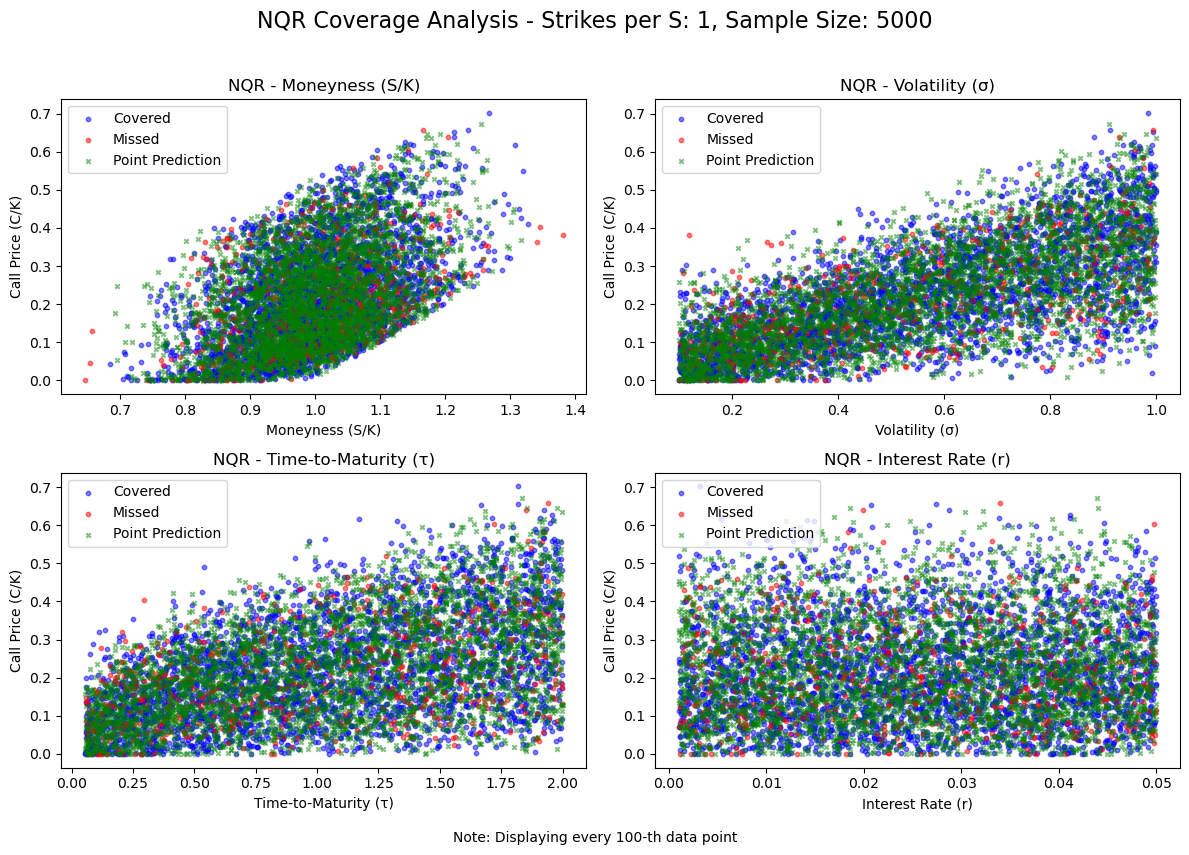

Processing Prediction Intervals: 100%|██████████| 4/4 [00:57<00:00, 14.33s/it]


Figure saved successfully at ../reports/figures/3.0-nm-figures-mapie/k_1_5000\NQR_PIs_K_1_5000.png


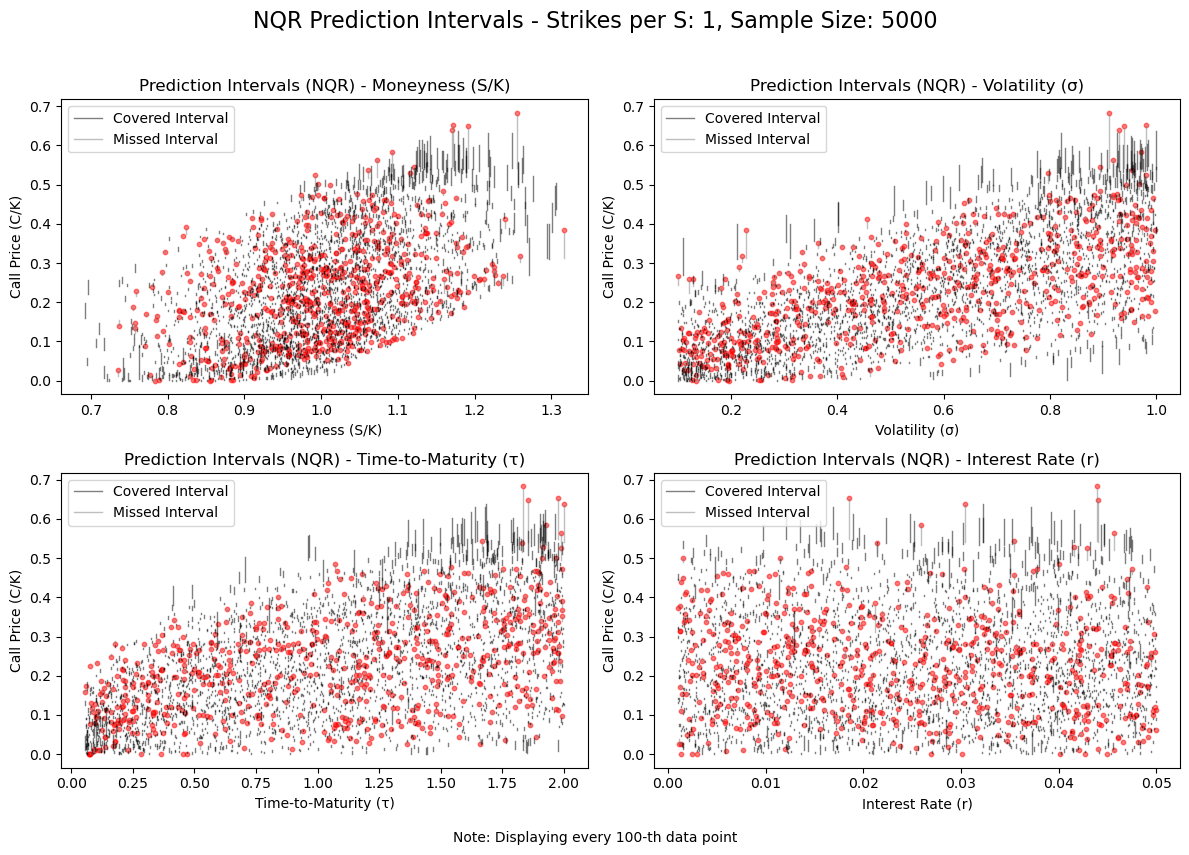

In [18]:
# Plot results for CQR
plot_covered_vs_missed(intervals_cqr_path, strikes_per_S, sample_size, 'CQR', n=100, plot_point_predictions=False)
plot_covered_vs_missed(intervals_cqr_path, strikes_per_S, sample_size, 'CQR', n=100, plot_point_predictions=True)
plot_prediction_intervals(intervals_cqr_path, strikes_per_S, sample_size, 'CQR', n=100)

# Plot results for NQR
plot_covered_vs_missed(intervals_nqr_path, strikes_per_S, sample_size, 'NQR', n=100, plot_point_predictions=False)
plot_covered_vs_missed(intervals_nqr_path, strikes_per_S, sample_size, 'NQR', n=100, plot_point_predictions=True)
plot_prediction_intervals(intervals_nqr_path, strikes_per_S, sample_size, 'NQR', n=100)